# PC = 6
# MSiA 421 - Data Mining Final Project

## Group 10

# Random Forest


In [33]:
# Libraries
import numpy as np
import pandas as pd
import zipfile
import time

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from umap import UMAP

import statsmodels.api as sm
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score

## Read data

In [34]:
## Reading the csv file directly from the zip file without extracting it
archive = zipfile.ZipFile('../02_Data/hotel_bookings_ohe.csv.zip', 'r')
files = archive.namelist()
with archive.open(files[0]) as csvfile:   
    df = pd.read_csv(csvfile)

df.head()

,arrival_date_year,adults,children,babies,previous_cancellations,booking_changes,total_of_special_requests,log_lead_time,total_nights,previous_bookings,...,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,required_car_parking_0,required_car_parking_1,is_canceled
0,2015,2,0,0,0,3,0,5.837730,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2015,2,0,0,0,4,0,6.603944,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2015,1,0,0,0,0,0,2.079442,1,0,...,0,0,1,0,0,0,0,1,0,0
3,2015,1,0,0,0,0,0,2.639057,1,0,...,0,0,1,0,0,0,0,1,0,0
4,2015,2,0,0,0,0,1,2.708050,2,0,...,1,0,1,0,0,0,0,1,0,0


## Clean data

In [35]:
df.drop(columns = ["market_segment_Undefined", "continent_Antarctica"], inplace = True)

In [36]:
# Number of observations and features
df.shape

(119388, 64)

In [37]:
# descriptive stats 
df.describe()

,arrival_date_year,adults,children,babies,previous_cancellations,booking_changes,total_of_special_requests,log_lead_time,total_nights,previous_bookings,...,market_segment_Offline TA/TO,market_segment_Online TA,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,required_car_parking_0,required_car_parking_1,is_canceled
count,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,...,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000
mean,2016.156548,1.856401,0.103888,0.007949,0.087119,0.221103,0.571372,3.840079,3.427865,0.224202,...,0.202851,0.473054,0.773177,0.006684,0.121143,0.089205,0.009792,0.937883,0.062117,0.370414
std,0.707478,0.579266,0.398558,0.097437,0.844343,0.652287,0.792802,1.609797,2.557380,1.827964,...,0.402124,0.499275,0.418779,0.081483,0.326295,0.285041,0.098467,0.241369,0.241369,0.482918
min,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.944439,2.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2016.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.248495,3.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2017.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.081404,4.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2017.000000,55.000000,10.000000,10.000000,26.000000,21.000000,5.000000,6.603944,69.000000,78.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# Featrue names 
df.columns

Index(['arrival_date_year', 'adults', 'children', 'babies',
       'previous_cancellations', 'booking_changes',
       'total_of_special_requests', 'log_lead_time', 'total_nights',
       'previous_bookings', 'log_days_in_waiting_list', 'log_adr',
       'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'booked_by_agent_no', 'booked_by_agent_yes', 'booked_by_company_0',
       'booked_by_company_1', 'continent_Africa', 'continent_Americas',
       'continent_Asia', 'continent_Europe', 'continent_Oceania',
       'continent_unknown', 'customer_type_Contract', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'domestic_domestic',
       'domestic_int

## Splitting trianing and test

In [39]:
# get train indexes
train_ind = pd.read_csv("../02_Data/train_index.csv")

# split train
train = df.iloc[train_ind.Train_Index,:]
train.reset_index(inplace = True, drop = True)
xtrain = train.drop("is_canceled", axis = 1)
ytrain = train.is_canceled

# Split test 
test = df.iloc[df.index.difference(train_ind.Train_Index),:]
xtest = test.drop("is_canceled", axis = 1)
ytest = test.is_canceled

In [40]:
# Check class imbalance in train and test 
print("Train Class Response:")
print(train.is_canceled.value_counts()/train.shape[0]*100)

print("Test Class Response:")
print(test.is_canceled.value_counts()/test.shape[0]*100)

Train Class Response:
0    62.941441
1    37.058559
Name: is_canceled, dtype: float64
Test Class Response:
0    63.027181
1    36.972819
Name: is_canceled, dtype: float64


## Fit Random Forest with sklearn

In [10]:
# Create random forest object 
rf = RandomForestClassifier(
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=190322)

# Define hyperparameters 
n_estimators = [150, 200, 250, 500]
min_samples_leaf = [3,4,5]
max_features = [2,3,4,5]

# dictionary of hyperparams 
hyperparms = dict(n_estimators = n_estimators, 
                 min_samples_leaf = min_samples_leaf, 
                 max_features = max_features)

# Use gridsearch to fit the model 
cv_hyper = GridSearchCV(rf, hyperparms, cv = 3, verbose = 0)
best_mod = cv_hyper.fit(xtrain, ytrain)
                                                                                                                                                                                                                             

KeyboardInterrupt: 

In [ ]:
# Print best hyperparams 
print("Best number of trees (n_estimators):", best_mod.best_estimator_.get_params()['n_estimators'])
print("Best node size (min_samples_leaf):", best_mod.best_estimator_.get_params()['min_samples_leaf'])
print("Best number of features (max_features):", best_mod.best_estimator_.get_params()['max_features'])

## Train best model

In [41]:
# create random forest object with best hyperparams
rf_model = RandomForestClassifier(
    n_estimators = 1000, 
    min_samples_leaf = 2, 
    max_features = 5, 
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=190322)


# start a timer
start_time = time.time()

# Estimate model 
rf_model.fit(xtrain, ytrain)

# end timers
end_time = time.time()

In [42]:
# time taken
time_taken = end_time - start_time
time_taken

21.662325859069824

## Variable Importance Measures

In [83]:
# Get the feature importances
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

In [84]:
#pd.DataFrame(data = [xtrain.columns, importances], columns = ['var', 'imp_index'])
var_imp = pd.DataFrame(data = xtrain.columns, columns = ['var'])
var_imp['index'] = importances

In [87]:
var_imp.sort_values('index', ascending = True, inplace = True)
var_imp.tail(10)

,var,index
4,previous_cancellations,0.029598
55,market_segment_Online TA,0.032857
8,total_nights,0.038580
42,domestic_international,0.056413
41,domestic_domestic,0.060338
6,total_of_special_requests,0.062014
11,log_adr,0.070577
38,deposit_type_No Deposit,0.079231
39,deposit_type_Non Refund,0.085715
7,log_lead_time,0.121016


<Figure size 10000x10000 with 0 Axes>

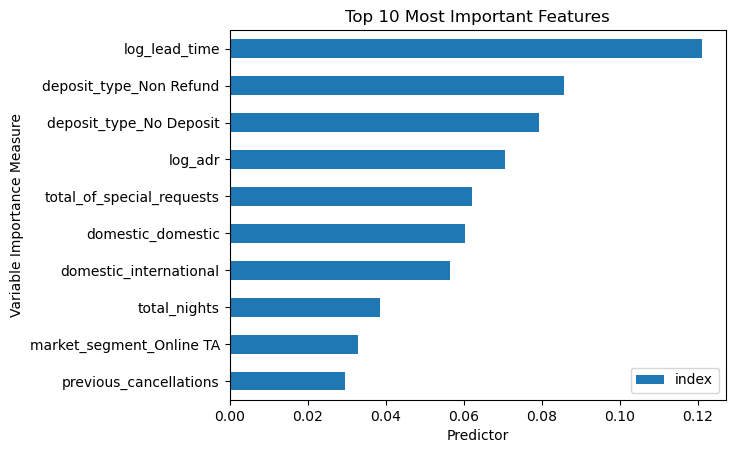

In [88]:
plt.figure(figsize=(100,100))
var_imp.iloc[-10:,].plot.barh(x='var', y='index')
plt.xlabel('Predictor') 
plt.ylabel('Variable Importance Measure') 
  
# displaying the title
plt.title("Top 10 Most Important Features")
plt.show()

In [93]:
from alepython import ale_plot

In [116]:
var_imp_top10 = list(var_imp.tail(10)['var'])
var_imp_top10

['previous_cancellations',
 'market_segment_Online TA',
 'total_nights',
 'domestic_international',
 'domestic_domestic',
 'total_of_special_requests',
 'log_adr',
 'deposit_type_No Deposit',
 'deposit_type_Non Refund',
 'log_lead_time']

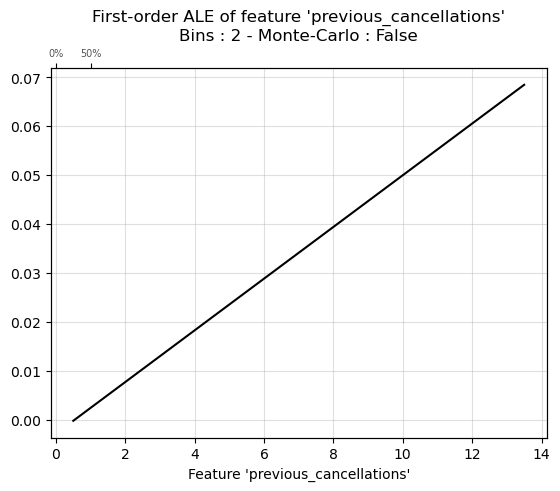

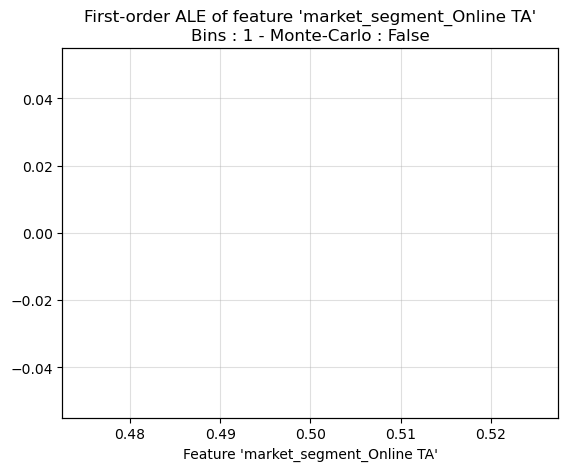

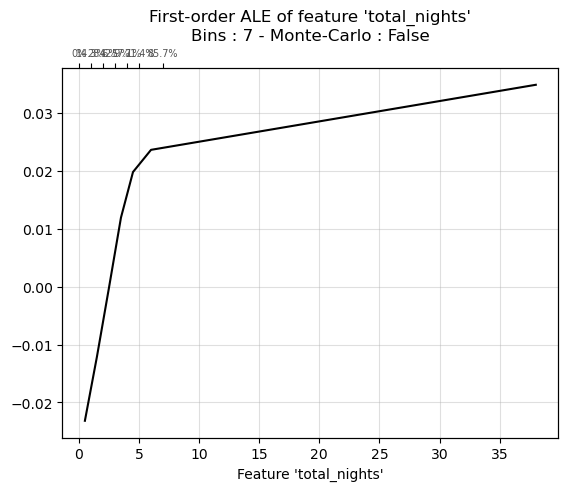

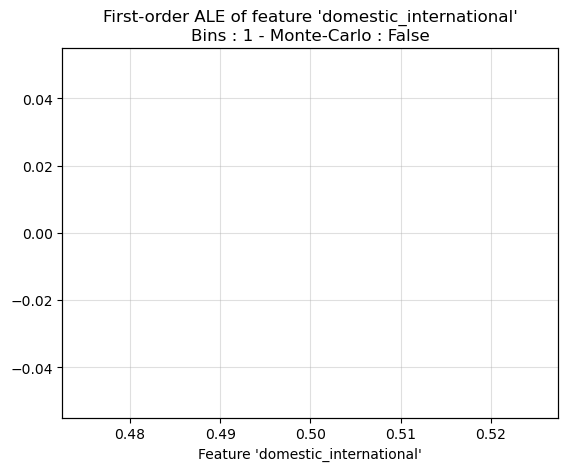

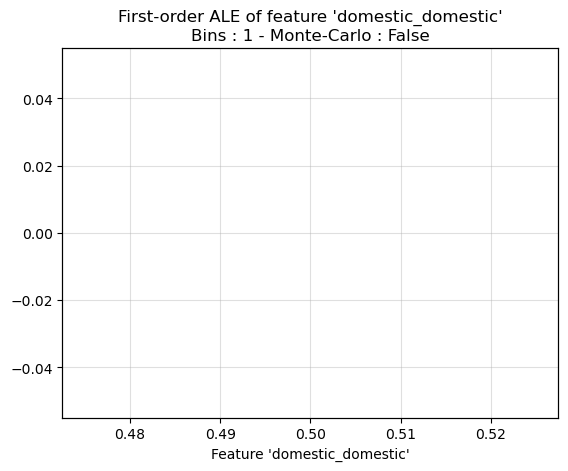

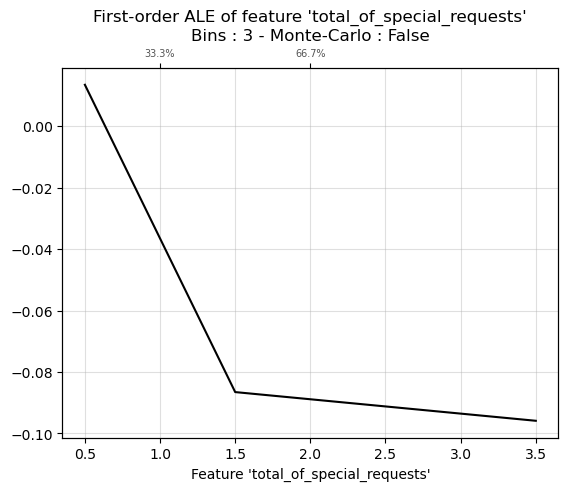

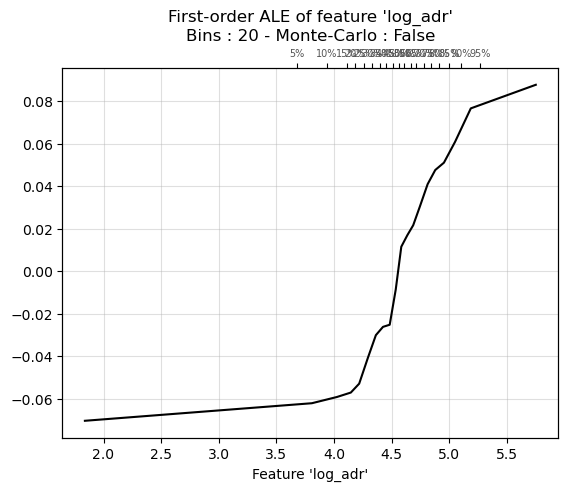

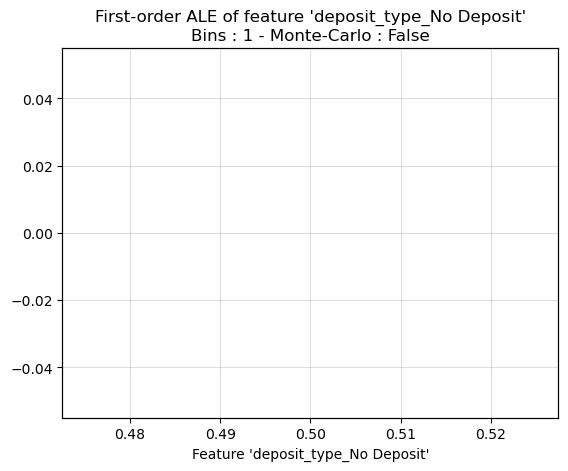

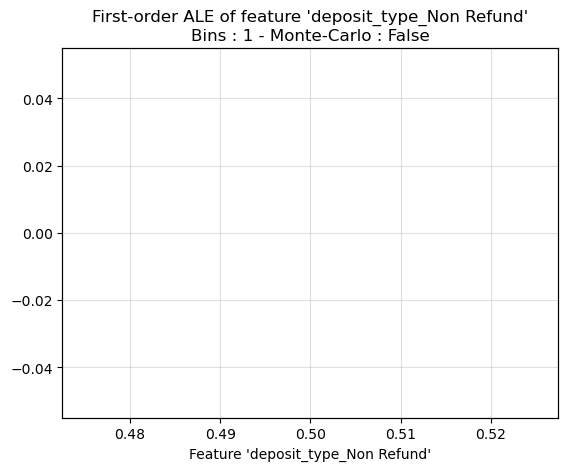

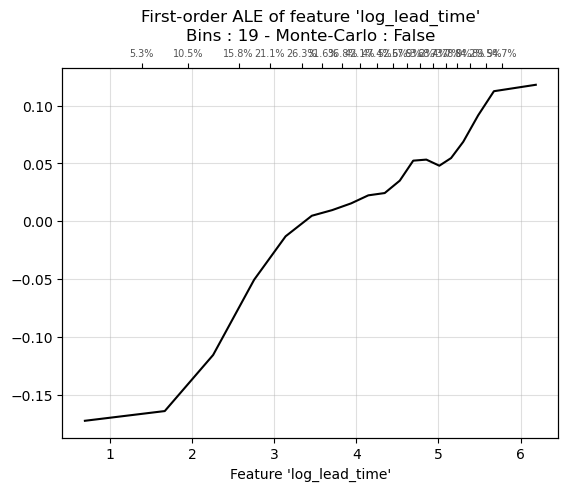

In [117]:
# ALE plot
for col in var_imp_top10:
    ale_plot(rf_model, xtrain, col, bins=20)

In [99]:
xtrain.columns

Index(['arrival_date_year', 'adults', 'children', 'babies',
       'previous_cancellations', 'booking_changes',
       'total_of_special_requests', 'log_lead_time', 'total_nights',
       'previous_bookings', 'log_days_in_waiting_list', 'log_adr',
       'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'booked_by_agent_no', 'booked_by_agent_yes', 'booked_by_company_0',
       'booked_by_company_1', 'continent_Africa', 'continent_Americas',
       'continent_Asia', 'continent_Europe', 'continent_Oceania',
       'continent_unknown', 'customer_type_Contract', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'domestic_domestic',
       'domestic_int

## Predict test set

In [13]:
# Predictions for test set 
yhat_test = rf_model.predict(xtest)

In [14]:
# --- Evaluation Metrics---
conf_matrix = confusion_matrix(ytest, yhat_test)
print('--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(ytest, yhat_test)))
print('Precision = {:.5f}'.format(precision_score(ytest, yhat_test)))
print('Recall = {:.5f}'.format(recall_score(ytest, yhat_test)))
print('F1 score = {:.5f}'.format(f1_score(ytest, yhat_test)))

--- EVALUATION METRICS ---:

Confusion Matrix:
[[14138   911]
 [ 1883  6945]]

Using 0.5 as threshold:
Accuracy = 0.88298
Precision = 0.88404
Recall = 0.78670
F1 score = 0.83253


## UMAP

In [15]:
# standardize the data
# Standardized data
xtrain_std = (xtrain-xtrain.mean())/xtrain.std()
xtrain_std.head()

,arrival_date_year,adults,children,babies,previous_cancellations,booking_changes,total_of_special_requests,log_lead_time,total_nights,previous_bookings,...,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,required_car_parking_0,required_car_parking_1
0,1.194993,0.255100,-0.259135,-0.079145,-0.103412,-0.339408,0.541822,0.509599,-0.557764,-0.121898,...,-0.445212,-0.506122,1.056149,-1.846930,-0.08367,2.698020,-0.313397,-0.098078,0.256244,-0.256244
1,-0.220670,-1.514575,-0.259135,-0.079145,-0.103412,-0.339408,-0.719787,-2.391451,-0.946569,-0.121898,...,-0.445212,-0.506122,-0.946826,0.541433,-0.08367,-0.370638,-0.313397,-0.098078,0.256244,-0.256244
2,1.194993,0.255100,2.254605,10.108526,-0.103412,1.200673,0.541822,0.803446,1.386263,-0.121898,...,-0.445212,-0.506122,1.056149,0.541433,-0.08367,-0.370638,-0.313397,-0.098078,0.256244,-0.256244
3,-0.220670,0.255100,-0.259135,-0.079145,-0.103412,-0.339408,-0.719787,-0.497503,-0.557764,-0.121898,...,-0.445212,-0.506122,-0.946826,0.541433,-0.08367,-0.370638,-0.313397,-0.098078,0.256244,-0.256244
4,1.194993,-1.514575,-0.259135,-0.079145,-0.103412,-0.339408,-0.719787,-1.960255,-0.946569,-0.121898,...,-0.445212,-0.506122,-0.946826,0.541433,-0.08367,-0.370638,-0.313397,-0.098078,0.256244,-0.256244


In [16]:
# Build UMAP object
num_comp=3

scikit_umap_2 = UMAP(n_components=num_comp, init='random', random_state=0,metric="hamming")
df_umap_2 = scikit_umap_2.fit_transform(xtrain_std)
xtrain_umap = pd.DataFrame(data =df_umap_2, columns = ['PC' + str(i+1) for i in range(num_comp)])
xtrain_umap.head()

/Users/lixuanchen/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


,PC1,PC2,PC3
0,8.921997,6.098740,3.773118
1,2.383554,1.116930,1.865242
2,5.646308,-3.729568,10.135358
3,2.775186,3.564275,2.460565
4,1.809889,2.908030,4.993055


In [16]:
# Create random forest object 
rf = RandomForestClassifier(
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=190322)

# Define hyperparameters 
n_estimators = [150, 200, 250, 500]
min_samples_leaf = [3,4,5]
max_features = [2,3,4,5]

# dictionary of hyperparams 
hyperparms = dict(n_estimators = n_estimators, 
                 min_samples_leaf = min_samples_leaf, 
                 max_features = max_features)

# Use gridsearch to fit the model 

start = time.time()
cv_hyper = GridSearchCV(rf, hyperparms, cv = 3, verbose = 0)
best_mod = cv_hyper.fit(xtrain_umap, ytrain)
print(time.time() - start)

# Print best hyperparams 
print("Best number of trees (n_estimators):", best_mod.best_estimator_.get_params()['n_estimators'])
print("Best node size (min_samples_leaf):", best_mod.best_estimator_.get_params()['min_samples_leaf'])
print("Best number of features (max_features):", best_mod.best_estimator_.get_params()['max_features'])

2108.482353925705
Best number of trees (n_estimators): 200
Best node size (min_samples_leaf): 5
Best number of features (max_features): 2


## Train best model with PCA 4

In [18]:
# create random forest object with best hyperparams
rf_model = RandomForestClassifier(
    n_estimators = 200, 
    min_samples_leaf = 5, 
    max_features = 2, 
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=190322)


# start a timer
start_time = time.time()

# Estimate model 
rf_model.fit(xtrain_umap, ytrain)

# end timers
end_time = time.time()

print(end_time - start_time)

10.294188976287842


## Fit test with PCA object

In [19]:
# standardize xtest
xtest_std = (xtest - xtest.mean()) / xtest.std()

In [ ]:
# Transform the test data
Xtest_umap = scikit_umap_2.transform(xtest_std)

/Users/lixuanchen/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [28]:
# Fit
xtest_umap = pd.DataFrame(data = Xtest_umap,
                          columns = ['PC' + str(i+1) for i in range(3)])

In [29]:
xtest_umap

,PC1,PC2,PC3
0,2.556954,3.152422,3.121784
1,8.088247,6.576527,5.270671
2,3.427117,4.750979,-0.935437
3,-4.602174,9.157632,-2.326607
4,3.465491,4.890643,-0.861559
...,...,...,...
23872,5.308075,-2.529312,9.767087
23873,3.813515,3.311643,7.658419
23874,5.324080,-3.706718,10.063030
23875,5.242518,-3.666275,10.044110


## Prediction on test using pca6

In [30]:
# Predictions for test set 
yhat_test_umap = rf_model.predict(xtest_umap)

In [31]:
# --- Evaluation Metrics---
conf_matrix = confusion_matrix(ytest, yhat_test_umap)
print('--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(ytest, yhat_test_umap)))
print('Precision = {:.5f}'.format(precision_score(ytest, yhat_test_umap)))
print('Recall = {:.5f}'.format(recall_score(ytest, yhat_test_umap)))
print('F1 score = {:.5f}'.format(f1_score(ytest, yhat_test_umap)))

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13296  1753]
 [ 4310  4518]]

Using 0.5 as threshold:
Accuracy = 0.74607
Precision = 0.72046
Recall = 0.51178
F1 score = 0.59845
